<a href="https://colab.research.google.com/github/casalazara/Machine-Learning-IELE/blob/master/Proyecto/Proyecto_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydub
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from google.colab import files
from pydub import AudioSegment
import librosa                    
import librosa.display
os.mkdir('./songs')
os.mkdir("./spectograms")

# Carga de datos

Se importa las librerías a usar y posteriormente los datos. Estos fueron generados anteriormente a partir de audios de 30 segundos de los distintos géneros musicales. Con las librerías librosa y matplotlib se generaron espectogramas de MEL de los audios, estas imágenes son las que nuestro modelo analizará.

## Directorio con los datos

In [2]:
drive.mount('/gdrive')
path = "../gdrive/MyDrive/spectograms"

Mounted at /gdrive


## Géneros

In [3]:
genres = ["Cumbia","Vallenato","Salsa","Merengue","Bachata"]

In [4]:
menor = 10000
for i in range(len(genres)):   
    genre=genres[i]
    cont = 0
    for img in os.listdir(path+"/"+genre):
      cont += 1
    if cont < menor:
      menor = cont

In [5]:
menor

634

## Separación de los datos

Los datos son separados en los conjuntos de entrenamiento, validación y prueba, además de ser clasificados según su género. Los 3 conjuntos son mutuamente excluyentes y serán utilizados por el modelo.

In [6]:
cont = 0
data = []
labels = []
for i in range(len(genres)):   
    genre=genres[i]
    cont = 0
    for img in os.listdir(path+"/"+genre):
      if cont == menor:
        break
      cont += 1
      image=tf.keras.preprocessing.image.load_img(path+"/"+genre+"/"+img, color_mode='rgb', target_size= (300,300))
      image=np.array(image)
      data.append(image)
      labels.append(i)

data = np.array(data)
labels = np.array(labels)
labels = to_categorical(labels, 5)
X_train, X_test_val, y_train, y_test_val = train_test_split(data, labels, test_size=0.2, random_state=42)
X_test,X_val,y_test,y_val = train_test_split(X_test_val,y_test_val,test_size=.5,random_state=42)
X_train.shape, X_test.shape, X_val.shape

((2536, 300, 300, 3), (317, 300, 300, 3), (317, 300, 300, 3))

In [7]:
X_train[:2]

array([[[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
        

In [8]:
y_train[:2]

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

Se prepara los datos de validación y entrenamiento para que funcionen correctamente en el modelo.

In [9]:
# Create an ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.)
validation_datagen = ImageDataGenerator(rescale = 1./255.)
X_test = X_test/255.
train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=8)

# Modelo


Se carga el modelo VGG16 el cuál ya está previamente entrenado en la clasificación de imágenes. 

## Carga del modelo

In [10]:
model=VGG16(include_top=False,input_shape=(300,300,3))

58892288/58889256 [==============================] - 1s 0us/step


## Congelamiento de capas

Se "congelan" las capas pertenecientes al modelo VGG16 de forma que estas no se modifiquen durante el entrenamiento. Posteriormente a este modelo le agregaremos 3 capas diseñadas para el conjunto de datos nuestro.

In [11]:
for layer in model.layers:
    layer.trainable=False

## Últimas capas

Se agregan las últimas capas orientadas al conjunto de imágenes que tenemos. La última capa tiene 5 neuronas pues hay 5 posibles clases.

In [12]:
output=model.layers[-1].output
model_final=tf.keras.layers.Flatten()(output)
model_final=tf.keras.layers.Dense(512,activation='relu')(model_final)
model_final=tf.keras.layers.Dense(64,activation='relu')(model_final)
model_final=tf.keras.layers.Dense(5,activation='softmax')(model_final)

## Modelo final

In [13]:
model=tf.keras.models.Model(model.input,model_final)

## Callback

Creamos un callback para que utilize como base los mejores pesos que encontramos para la identificación de los géneros de estas canciones.

In [14]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, weights_dir, patience=10, rate=0.5):
        """
        Initializer Method
        :param weights_dir: The directory of the model weights
        :param patience: Number of epochs before reducing lr
        :param rate: The rate to reduce the lr
        """
        super(CustomCallback, self).__init__()
        self.weights_dir = weights_dir
        self.rate = rate
        self.patience = patience

    def on_train_begin(self, logs=None):
        """
        Configurations to be taken an account on
        before training begins.
        :param logs: The logs from the output.
        """
        self.best_loss = np.Inf
        self.best_acc = 0
        self.wait = 0
        self.best_weights = None
    
    def on_epoch_end(self, epoch, logs=None):
        """
        Method that is called each time an epoch ends
        excecution
        :param epoch: The current epoch of the training
        :param logs: The logs from the output from an epoch ended
        """
        # Current validation loss
        current_loss = logs.get("val_loss")
        # Current validation Accuracy
        current_acc = logs.get("val_acc")
        if (current_loss < self.best_loss and 
            current_acc > self.best_acc):
            # We save the model weights
            # We wait again
            # We assign the best loss and the best accuracy.
            self.wait = 0
            self.best_loss = current_loss
            self.best_acc = current_acc
            self.model.save_weights(self.weights_dir)
            self.best_weights = self.model.get_weights()
            print("\nBest Weights Saved!!")
        else:
            self.wait += 1
            if self.wait >= self.patience:
                # Reduce learning rate by the initialized rate.
                self.wait = 0
                print(f"\nEpoch {epoch}, Reducing Learning Rate")
                # We set the new learning rate
                lr = K.get_value(self.model.optimizer.lr)
                new_lr = lr * self.rate
                K.set_value(self.model.optimizer.lr, new_lr)
                print(f"\nLearning Rate Reduced: {new_lr}")
                # We load the best weights to continue the training.
                self.model.set_weights(self.best_weights)
                print("\nBest Weights Loaded!!")

## Compilación

In [15]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

## Resumen del modelo

In [16]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)      

In [17]:
weights_path = path + "/weights/"

## Entrenamiento

Se entrena el modelo haciendo uso de los mejores pesos obtenidos con el callback.

In [23]:
history = model.fit_generator(train_generator, epochs=5,
                              validation_data = validation_generator, 
                              callbacks = [CustomCallback(weights_path+'train_best_weights_3.h5')])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
317/317 [==============================] - ETA: 0s - loss: 0.7943 - acc: 0.7094
Best Weights Saved!!
317/317 [==============================] - 2546s 8s/step - loss: 0.7943 - acc: 0.7094 - val_loss: 0.8065 - val_acc: 0.6940
Epoch 2/5
317/317 [==============================] - ETA: 0s - loss: 0.5472 - acc: 0.7946
Best Weights Saved!!
317/317 [==============================] - 2533s 8s/step - loss: 0.5472 - acc: 0.7946 - val_loss: 0.5558 - val_acc: 0.8044
Epoch 3/5
317/317 [==============================] - 2521s 8s/step - loss: 0.4455 - acc: 0.8356 - val_loss: 0.5673 - val_acc: 0.8044
Epoch 4/5
317/317 [==============================] - 2520s 8s/step - loss: 0.3460 - acc: 0.8667 - val_loss: 0.5687 - val_acc: 0.7981
Epoch 5/5
317/317 [==============================] - ETA: 0s - loss: 0.2777 - acc: 0.8951
Best Weights Saved!!
317/317 [==============================] - 2516s 8s/step - loss: 0.2777 - acc: 

Evaluamos el desempeño del modelo con el conjunto de prueba. Se ve un accuracy alto y pérdida relativamente baja.

In [24]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss}, Test acc: {test_acc}')

Test loss: 0.3815688490867615, Test acc: 0.8769716024398804


## Evaluación

Se genera una gráfica para evidenciar mejor los resultados.

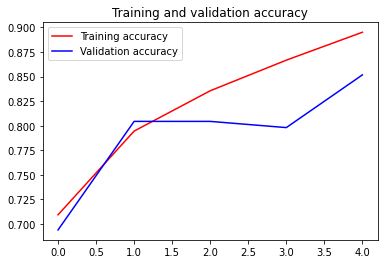

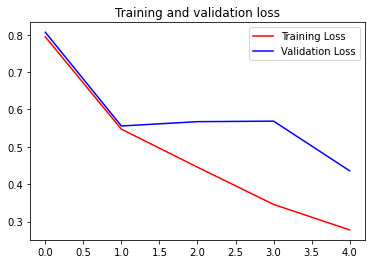

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Guardado del modelo y pesos

In [ ]:
model.save_weights(weights_path+'latest_weights_3.h5')
model.save(weights_path+'model_3.h5')

## Carga de pesos 

In [21]:
model.load_weights(weights_path+'train_best_weights_3.h5')

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss}, Test acc: {test_acc}')

# Prueba del modelo

In [ ]:
def split_song(song):
  sound = AudioSegment.from_mp3(song)
  # len() and slicing are in milliseconds
  segment_size = 30000
  parts = len(sound) // segment_size
  for i in range(parts):
    if segment_size*(i+1) < len(sound):
      temp = sound[segment_size*i: segment_size*(i+1)]
      temp.export(f'{songs_path}/{song.replace(".mp3","")+"_"+str(i)}.mp3', format='mp3')

def get_spectograms(song, img_dir="./spectograms"):
  for fil in os.listdir(songs_path):
        if fil.startswith(song.replace(".mp3","")):
            y, sr = librosa.load(os.path.join(songs_path,fil))
            melSpec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            melSpec_dB = librosa.power_to_db(melSpec, ref=np.max)
            plt.figure(figsize=(10, 5))
            librosa.display.specshow(melSpec_dB, sr=sr, fmax=8000)
            plt.tight_layout()
            plt.savefig(img_dir+'/'+fil.split('.mp3')[0][:]+".png")
            plt.close()

def pre_process(song,img_dir="./spectograms"):
  data = []
  for fil in os.listdir(img_dir):
    if fil.startswith(song.replace(".mp3","")):
      image=tf.keras.preprocessing.image.load_img(img_dir+"/"+fil, color_mode='rgb', target_size= (300,300))
      image=np.array(image)
      data.append(image)
  return np.array(data)/.255

def predict_voting(predictions):
  votes = {}
  for prediction in predictions:
    pos = np.argmax(prediction)
    if genres[pos] in votes:
      votes[genres[pos]]+=1
    else:
      votes[genres[pos]]=1
  count = [ (genre,count) for genre, count in votes.items()]
  print("Votos: ",count)
  count.sort(key=lambda x: x[1],reverse=True)
  return count[0]

def predict_sum(predictions):
  result_sum = np.sum(predictions,axis=0)
  pos = np.argmax(result_sum)
  result = {genres[i]: result_sum[i] for i in range(len(genres))}
  print("Sumas: ", result)
  return (genres[pos], result_sum[pos])

In [ ]:
songs_path = './songs'
uploaded = files.upload()

In [ ]:
for song in uploaded:
  split_song(song)
  get_spectograms(song)
  specs = pre_process(song)
  predictions = model.predict(specs)
  print("Predicciones para la canción: ", song, 
        "\n Ganador por votación: ", predict_voting(predictions), 
        "\n Ganador por suma: ", predict_sum(predictions))
  print(genres)
  print("Probabilidades por parte: ", predictions)
  print("#"*300)

In [ ]:
g = {}
for row in y_train:
  pos = np.argmax(row)
  if genres[pos] not in g:
    g[genres[pos]] = 1
  else:
    g[genres[pos]] +=1
plt.bar([x for x in g],[g[x] for x in g])